# ETS Example with Numpyro

This is a working example to compare results on ETS model between estimator `Numpyro` and estimator `PyStan`.

In [1]:
import pandas as pd
import numpy as np
import orbit
import matplotlib.pyplot as plt

from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, params_comparison_boxplot
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())
from orbit.models import ETS

In [2]:
orbit.__version__

'1.1.3dev'

In [3]:
print(np.__version__)

1.22.2


In [4]:
%load_ext autoreload
%autoreload 2

## Data

In [5]:
# can also consider transform=False
raw_df = load_iclaims(transform=True)
raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [6]:
df = raw_df.copy()
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [7]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## Comparing MCMC Results

If users see a warning messages about `tree_flatten(xs)`, feel free to ignore them.

In [8]:
%%time
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='numpyro-mcmc',
          num_warmup=3000,
          num_sample=1000,
          chains=4,
)
ets.fit(train_df);

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:orbit:Sampling (NumPyro) with chains: 4, cores: 1, warmups (per chain): 750 and samples(per chain): 250.
/Users/towinazure/edwinnglabs/orbit/orbit/estimators/numpyro_estimator.py:74: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using

CPU times: user 9.58 s, sys: 105 ms, total: 9.68 s
Wall time: 9.67 s


In [9]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95
0,2010-01-03,13.273474,13.386167,13.490610,12.929458,13.058377,13.170282,0.286855,0.330960,0.377579
1,2010-01-10,13.488315,13.625053,13.764342,12.942616,13.059656,13.176730,0.470347,0.565782,0.655681
2,2010-01-17,13.243209,13.388501,13.521460,12.945493,13.057982,13.183508,0.223653,0.322527,0.424910
3,2010-01-24,13.001969,13.142340,13.281885,12.945649,13.053961,13.169576,-0.008067,0.086431,0.178570
4,2010-01-31,13.027290,13.176325,13.311343,12.951854,13.062768,13.171398,0.005389,0.108519,0.210629
...,...,...,...,...,...,...,...,...,...,...
438,2018-05-27,12.147893,12.342053,12.536748,12.240414,12.439043,12.633855,-0.111080,-0.098627,-0.082220
439,2018-06-03,12.067353,12.273009,12.477340,12.234355,12.441770,12.647639,-0.182182,-0.167376,-0.146255
440,2018-06-10,12.175553,12.371882,12.574991,12.244053,12.436790,12.642559,-0.081362,-0.066892,-0.047028
441,2018-06-17,12.129562,12.342296,12.539775,12.221354,12.438750,12.634631,-0.111655,-0.096795,-0.075732


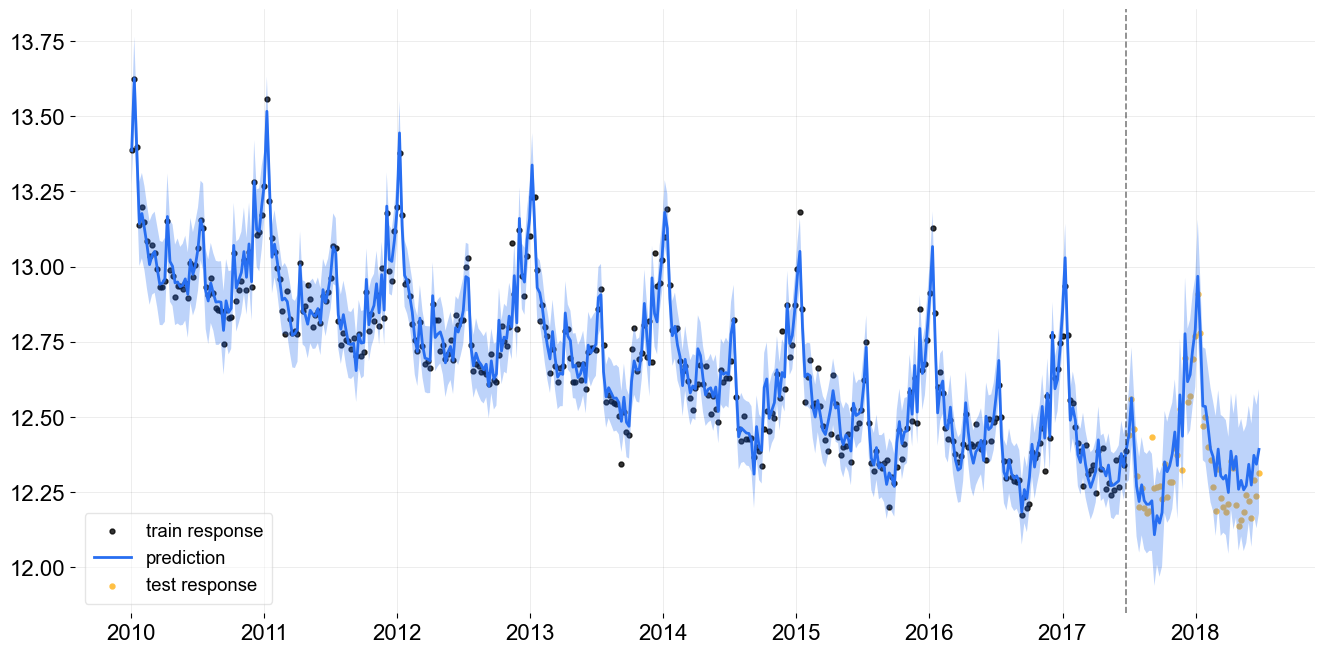

In [10]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col='week',
                        actual_col='claims',
                        test_actual_df=test_df)

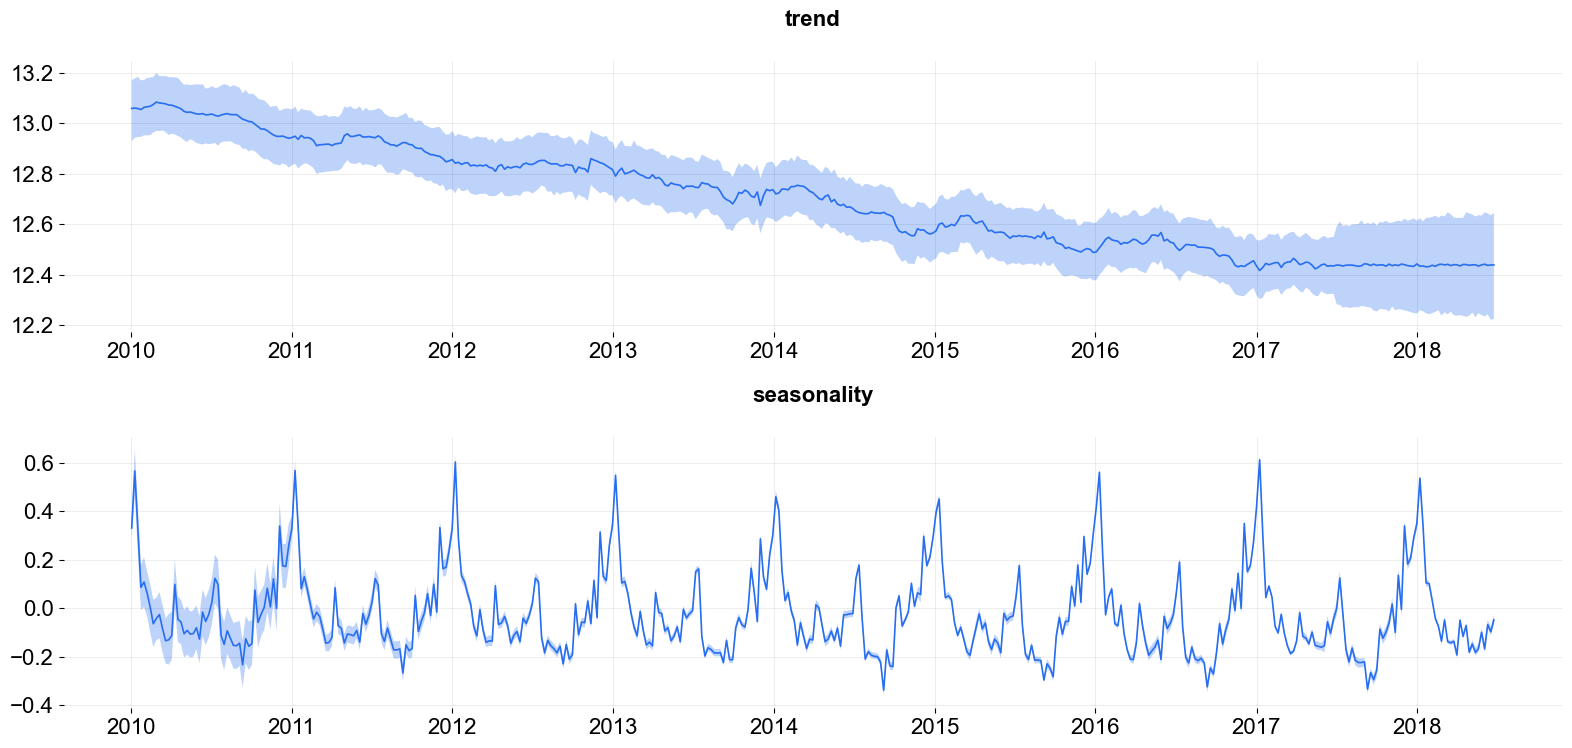

In [11]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col='week')

In [12]:
numpyro_ps = ets.get_posterior_samples()

In [13]:
%%time
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='stan-mcmc',
          num_warmup=3000,
          num_sample=1000,
          chains=4,
)
ets.fit(train_df);

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 83.7 ms, sys: 86.1 ms, total: 170 ms
Wall time: 2.33 s


In [14]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95
0,2010-01-03,13.277987,13.386926,13.501071,12.930427,13.056506,13.176938,0.289711,0.334267,0.378728
1,2010-01-10,13.481950,13.625752,13.756561,12.941126,13.058066,13.170436,0.469029,0.567175,0.658791
2,2010-01-17,13.244758,13.383253,13.526405,12.944540,13.058457,13.181706,0.231360,0.323579,0.416855
3,2010-01-24,12.996177,13.136885,13.277578,12.930651,13.055104,13.174402,-0.013922,0.083862,0.180803
4,2010-01-31,13.038686,13.175844,13.307648,12.942839,13.062441,13.173764,0.024911,0.109685,0.198314
...,...,...,...,...,...,...,...,...,...,...
438,2018-05-27,12.138995,12.341605,12.532757,12.234585,12.441406,12.629492,-0.112115,-0.098429,-0.081842
439,2018-06-03,12.073240,12.275181,12.474636,12.238868,12.441932,12.637544,-0.181310,-0.166659,-0.144448
440,2018-06-10,12.176351,12.371324,12.560502,12.243247,12.439350,12.622176,-0.081234,-0.066456,-0.045729
441,2018-06-17,12.136261,12.342718,12.543486,12.236338,12.438696,12.634156,-0.112190,-0.096027,-0.074182


In [15]:
stan_ps = ets.get_posterior_samples()

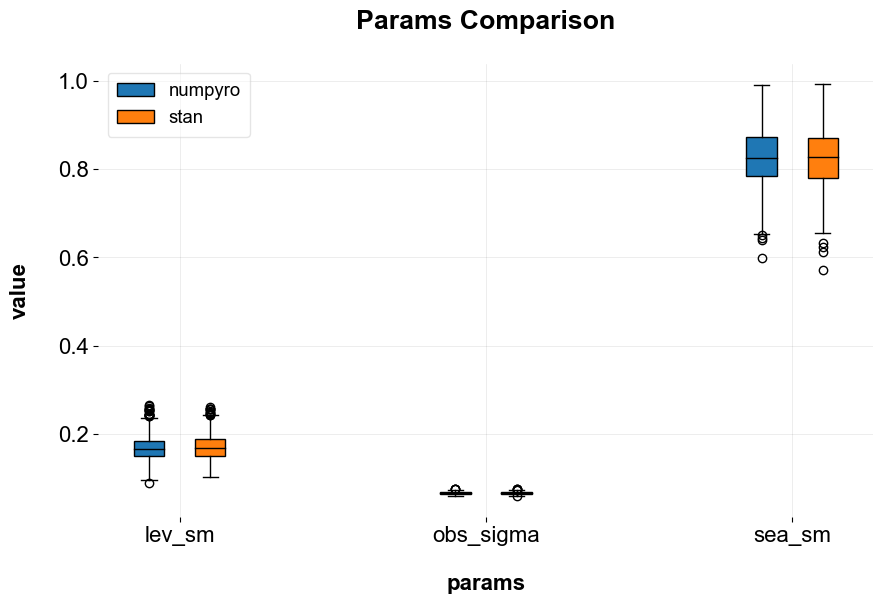

In [16]:
params_comparison_boxplot(
        [numpyro_ps, stan_ps],
        var_names=['lev_sm', 'obs_sigma', 'sea_sm'],
        model_names=["numpyro", "stan"],
        box_width = .1, box_distance=0.1,
        showfliers=True
);

## Comparing MAP Results

In [17]:
%%time
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='numpyro-map',
          num_iters=5000,
)
ets.fit(train_df);
numpyro_posteriors = ets.get_point_posteriors()['map']

/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
100%|█████████████████████| 5000/5000 [00:01<00:00, 3176.88it/s, init loss: 724.8259, avg. loss [4751-5000]: -526.9331]


CPU times: user 3.71 s, sys: 82.7 ms, total: 3.79 s
Wall time: 3.59 s


In [18]:
%%time
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='stan-map',
          num_iters=5000,
)
ets.fit(train_df);
stan_posteriors = ets.get_point_posteriors()['map']

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS and max iterations: 5000.


CPU times: user 10.4 ms, sys: 2.15 ms, total: 12.5 ms
Wall time: 11.8 ms


In [19]:
print("----NumPyro---")
for param in ['lev_sm', 'obs_sigma', 'sea_sm']:
    print('{}: {:.5f}'.format(param, numpyro_posteriors[param].mean()))
print("----PyStan---")  
for param in ['lev_sm', 'obs_sigma', 'sea_sm']:
    print('{}: {:.5f}'.format(param, stan_posteriors[param].mean()))

----NumPyro---
lev_sm: 0.26436
obs_sigma: 0.05119
sea_sm: 0.40222
----PyStan---
lev_sm: 0.17741
obs_sigma: 0.06141
sea_sm: 0.77071


## Conclusion

The NUTS algorithm results are similar between `PyStan` and `NumPyro`. `NumPyro` has a slower runtime due to `1 core` setting constraints which need to be further investigated.  The MAPS algorithm generates different result from those two APIs. It is possible due to different initialization although `PyStan` result is closer to the NUTS result.